# Super-resolución con U-net Pytorch

### Tarea 1 Aprendizaje Maquina II

Mario Xavier Canche Uc, 02/Septiembre/2020, CIMAT GTO

## Cargamos las librerias

In [ ]:
# Cargamos las librerias
import matplotlib.pyplot as plt
import numpy as np
import os
import time 

In [ ]:
# Definición de parametros
batch_size        = 32  # el paper original usa un tamaño de 128
epochs            = 200
data_augmentation = True
num_classes       = 10
subtract_pixel_mean = True  # substrae la media a cada parche (mejor el error)

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
#from tensorflow.keras.layers import Lambda, Input
import cv2 

In [ ]:
# Cargar datos de Cifar-10 (Keras las descargara por nosotros la primera vez)
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

y_train = train_images.copy()
y_test = test_images.copy()
print(y_train.shape)

# Redimensionamos
#train_images = np.array([ cv2.resize(img, (14, 14))  for img in train_images])
#test_images = np.array([ cv2.resize(img, (14, 14))  for img in test_images])

y_train = np.array([ cv2.resize(img, (56, 56))  for img in y_train])
y_test = np.array([ cv2.resize(img, (56, 56))  for img in y_test])

input_shape = train_images.shape[1:]

print('Dimensiones del conjunto de entrenamiento: ', train_images.shape)
print('Dimensiones del conjunto de evaluación: ',    test_images.shape)

(60000, 28, 28)
Dimensiones del conjunto de entrenamiento:  (60000, 28, 28)
Dimensiones del conjunto de evaluación:  (10000, 28, 28)


In [ ]:
input_shape

(28, 28)

In [ ]:
# Normalización de los datos [0,1]
x_train = np.copy(train_images).astype('float64')/255.
y_train = np.copy(y_train).astype('float64')/255.
x_test  = np.copy(test_images).astype('float64')/255.
y_test  = np.copy(y_test).astype('float64')/255.

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
### Substracción de la media (mejora el desempeño)
##if subtract_pixel_mean:
##    x_train_mean = np.mean(x_train, axis=0)
##    x_train -= x_train_mean
##    x_test -= x_train_mean

# Añadimos el ruido
sigma = 0.15
##x_train += np.random.normal(loc=0, scale=sigma, size=x_train.shape)
##x_test  += np.random.normal(loc=0, scale=sigma, size=x_test.shape)

#x_train += np.random.normal(loc=0, scale=sigma, size=x_train.shape)
#x_test  += np.random.normal(loc=0, scale=sigma, size=x_test.shape)

# y_train = y_train>0.5
# y_test  = y_test>0.5

(60000, 28, 28)
(60000, 56, 56)
(10000, 28, 28)
(10000, 56, 56)


(28, 28)
(56, 56)
(28, 28)
(56, 56)
(28, 28)
(56, 56)
(28, 28)
(56, 56)
(28, 28)
(56, 56)
(28, 28)
(56, 56)
(28, 28)
(56, 56)
(28, 28)
(56, 56)
(28, 28)
(56, 56)
(28, 28)
(56, 56)


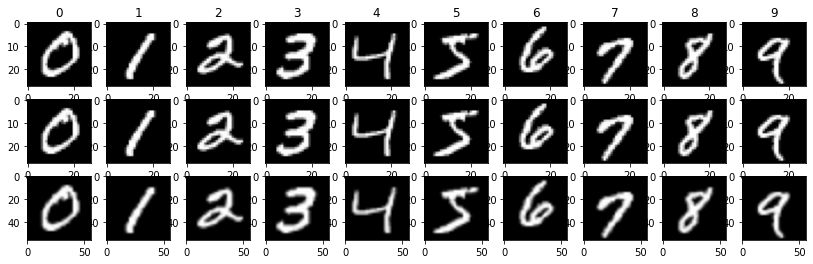

In [ ]:
# Visualizamos algunos ejemplos de imagenes
imgs=10
plt.figure(figsize=(14,4))
for i in range(imgs):
    plt.subplot(3,imgs,i+1)
    idx = list(train_labels).index(i)
    plt.imshow(train_images[idx], 'gray')
    plt.title(train_labels[idx])
    #plt.axis('off')
    
    plt.subplot(3,imgs,i+1+imgs)
    idx = list(train_labels).index(i)
    plt.imshow(x_train[idx], 'gray')
    #plt.title(train_labels[idx])
    #plt.axis('off')
    print(x_train[idx].shape)

    plt.subplot(3,imgs,i+1+2*imgs)
    idx = list(train_labels).index(i)
    plt.imshow(y_train[idx], 'gray')
    #plt.title(train_labels[idx])
    #plt.axis('off')
    print(y_train[idx].shape)

In [ ]:
# Expandimos a una dimensión extra
#x_train = np.expand_dims(x_train, axis=3)
#y_train = np.expand_dims(y_train, axis=3)
#x_test  = np.expand_dims(x_test,  axis=3)
#y_test  = np.expand_dims(y_test,  axis=3)

print('Dimensiones de entradas (X) para entrenamiento  (imagenes x rows x cols) =', x_train.shape)
print('Dimensiones de saida (Y) para entrenamiento     (imagenes x rows x cols) =', y_train.shape)
print('Dimensiones de entradas (X) para evaluación     (imagenes x rows x cols) =', x_test.shape)
print('Dimensiones de saida (Y) para evaluación        (imagenes x rows x cols) =', y_test.shape)

Dimensiones de entradas (X) para entrenamiento  (imagenes x rows x cols) = (60000, 28, 28)
Dimensiones de saida (Y) para entrenamiento     (imagenes x rows x cols) = (60000, 56, 56)
Dimensiones de entradas (X) para evaluación     (imagenes x rows x cols) = (10000, 28, 28)
Dimensiones de saida (Y) para evaluación        (imagenes x rows x cols) = (10000, 56, 56)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras import optimizers
#from tensorflow.keras.backend import tf as tf
from tensorflow.keras.layers import Lambda, Input

In [ ]:
x_train.shape

(60000, 28, 28)

In [ ]:
# `filters_per_block` define el número de canales en cada etapa de la Unet, 
# la profundidad de la Unet se adapta de acuerdo a la longitud de dicha lista.
_, num_rows, num_cols = y_train.shape
num_channels = 1
img_dim          = (num_rows, num_cols, num_channels,)
#filters_per_block = np.array([num_channels, 32, 64, 128])
#filters_per_block = np.array([num_channels, 28, 56])
filters_per_block = np.array([num_channels, 56, 112])
num_blocks        = len(filters_per_block)   
kernel_size       = (3,3)
drop              = 0.25*np.ones(num_blocks)


# Encoder

nm= 'encoder'
Xdicc={}

Xin  = Input(shape=img_dim, name="x_true")

##X = Lambda(lambda image: tf.image.resize(image, (32, 32)))(Xin)
#X = Lambda(lambda image: tf.image.resize(image, (28, 28)))(Xin)
X = Lambda(lambda image: tf.image.resize(image, (56, 56)))(Xin)
# resize image layer
Xdicc[0] = X
numFilters=filters_per_block[0]
print(0, numFilters, X.shape)

for i in range(1,num_blocks):
    numFilters=filters_per_block[i]
    X = Conv2D(numFilters, kernel_size=kernel_size, padding='same', activation='relu', name='encoder-conv1'+str(i))(X) 
    X = Conv2D(numFilters, kernel_size=kernel_size, padding='same', activation='relu', name='encoder-conv2'+str(i))(X)
    X = Dropout(rate=drop[i], name='encoder-drop'+str(i))(X)
    X = MaxPooling2D(pool_size=(2,2), padding='valid', name='encoder-maxpool'+str(i))(X)
    Xdicc[i] = X
    print(i, numFilters, Xdicc[i].shape) 
print("Fin del Encoder...")
# Decoder

Y=X
for i in range(num_blocks-1,0,-1):
    if i>1:
        numFilters = filters_per_block[i-1] 
    else:
        numFilters = 32
    #print(i, numFilters, Y.shape, Xdicc[i-1].shape)
    Y = UpSampling2D(size=2, name='decoder-up'+str(i))(Y)  
    print(i, numFilters, Y.shape, Xdicc[i-1].shape)
    Y = Concatenate(name='decoder-concat'+str(i))([Y, Xdicc[i-1]])
    print(i, numFilters, Y.shape, Xdicc[i-1].shape)
    Y = Conv2D(numFilters, kernel_size=(3,3), padding='same', activation='relu', name='decoder-conv2'+str(i))(Y)
    Y = Conv2D(numFilters, kernel_size=(3,3), padding='same', activation='relu', name='decoder-conv3'+str(i))(Y)
    Y = Dropout(rate=drop[i], name='decoder-drop'+str(i))(Y)

##Y = UpSampling2D(size=2, name='decoder-up-Final')(Y)  
##print(i, numFilters, Y.shape, Xdicc[i-1].shape)
###Y = Concatenate(name='decoder-concat'+str(i))([Y, Xdicc[i-1]])
##print(i, numFilters, Y.shape, Xdicc[i-1].shape)
##Y = Conv2D(numFilters, kernel_size=(3,3), padding='same', activation='relu', name='decoder-conv2-Final')(Y)
##Y = Conv2D(numFilters, kernel_size=(3,3), padding='same', activation='relu', name='decoder-conv3-Final')(Y)
##Y = Dropout(rate=drop[i], name='decoder-drop-Final')(Y)
    
# Tail 

Y = Conv2D(6, kernel_size=(3,3), 
           padding='same', 
           activation=None,
           name='tail-2xch')(Y)

Yout = Conv2D(1, kernel_size=(1,1), 
           padding='same', 
           activation=None, 
           name='tail-last')(Y)
#Yout = Lambda(lambda image: tf.image.resize(image, (num_rows, num_cols)))(Y)
     

0 1 (None, 56, 56, 1)
1 56 (None, 28, 28, 56)
2 112 (None, 14, 14, 112)
Fin del Encoder...
2 56 (None, 28, 28, 112) (None, 28, 28, 56)
2 56 (None, 28, 28, 168) (None, 28, 28, 56)
1 32 (None, 56, 56, 56) (None, 56, 56, 1)
1 32 (None, 56, 56, 57) (None, 56, 56, 1)


In [ ]:
# Instancia el modelo
unet = Model(inputs =Xin,  outputs=[Yout],  name   ='RUnet')

In [ ]:
# Parametros de entrenamiento

epochs     = 5         # número de épocas
batch_size = 64        # tamaño del lote
alpha      = 0.0001    # razon de aprendizaje
decay      = 0.0001    # decaimiento de alpha

In [ ]:
# Definimos la función de optimización
unet.compile(optimizer =optimizers.Adam(lr=alpha, decay=decay),
             loss      = 'mae',
             metrics   = ['accuracy'])

In [ ]:
x_train.shape

(60000, 28, 28)

In [ ]:
y_train.shape

(60000, 56, 56)

In [ ]:
tic = time.time()
history = unet.fit(x               = x_train,
                   y               = y_train,
                   batch_size      = batch_size,
                   epochs          = epochs,
                   validation_split= 0.2,
                   verbose         = 1)
print('\n Tiempo de entrenamiento:', time.time()-tic, 'segundos')

Epoch 1/5
750/750 [==============================] - 57s 76ms/step - loss: 0.0160 - accuracy: 0.7476 - val_loss: 0.0029 - val_accuracy: 0.7477
Epoch 2/5
750/750 [==============================] - 57s 76ms/step - loss: 0.0077 - accuracy: 0.7477 - val_loss: 0.0021 - val_accuracy: 0.7477
Epoch 3/5
750/750 [==============================] - 56s 75ms/step - loss: 0.0067 - accuracy: 0.7477 - val_loss: 0.0018 - val_accuracy: 0.7477
Epoch 4/5
750/750 [==============================] - 56s 75ms/step - loss: 0.0061 - accuracy: 0.7477 - val_loss: 0.0017 - val_accuracy: 0.7477
Epoch 5/5
750/750 [==============================] - 56s 75ms/step - loss: 0.0059 - accuracy: 0.7477 - val_loss: 0.0016 - val_accuracy: 0.7477

 Tiempo de entrenamiento: 290.6531684398651 segundos


In [ ]:
# Predicción

tic = time.time()
y_train_pred = unet.predict(x_train)
print('\n Tiempor de predicción de todos los datos de prueba:', time.time()-tic, 'segundos')


 Tiempor de predicción de todos los datos de prueba: 17.776122570037842 segundos


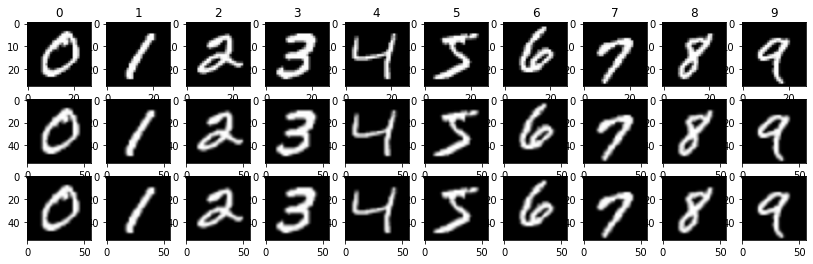

(60000, 56, 56, 1)

In [ ]:
imgs=10

plt.figure(figsize=(14,4))
for i in range(10):
    plt.subplot(3,imgs,i+1)
    idx = list(train_labels).index(i)
    plt.imshow(x_train[idx,:,:], 'gray')
    plt.title(train_labels[idx])
    #plt.axis('off')

    plt.subplot(3,imgs,i+1+imgs)
    idx = list(train_labels).index(i)
    plt.imshow(y_train[idx,:,:], 'gray')
    #plt.axis('off')
    
    plt.subplot(3,imgs,i+1+2*imgs)
    idx = list(train_labels).index(i)
    plt.imshow(y_train_pred[idx,:,:,0], 'gray')
    #plt.axis('off')
plt.show()
y_train_pred.shape

In [ ]:
y_train_pred.shape

(60000, 56, 56, 1)

In [ ]:
x_train.shape

(60000, 28, 28)

## Guardamos y descargamos el modelo entrenado

In [ ]:
from google.colab import files

# Guardamos el Modelo
unet.save('R_UNET.h5')

# Descargamos de Colab a la PC
files.download('/content/R_UNET.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
%ls

R_UNET.h5  sample_data/


## Cargamos el Modelo

In [ ]:
from tensorflow.keras.models import load_model

# Cargamos el Modelo entrenado
model = load_model("/content/R_UNET.h5")

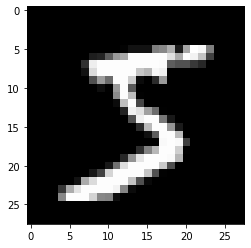

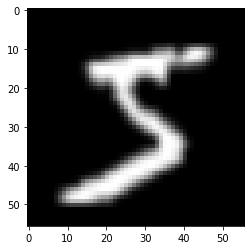

In [ ]:
x_img = x_train[0]

x = np.expand_dims(x_img, axis=0)
preds = model.predict(x).squeeze((0,3))

plt.imshow(x_img, 'gray')
#plt.axis('off')
plt.show()

plt.imshow(preds, 'gray')
#plt.axis('off')
plt.show()